In [1]:
# map torch.tensor.cuda to dummy function to prevent errors on systems without a GPU
import torch

def dummy_cuda(self, device=None, non_blocking=False):
    return self  # just return the same tensor (on CPU)

torch.Tensor.cuda = dummy_cuda
torch.nn.Module.cuda = dummy_cuda

In [2]:
%load_ext autoreload
%autoreload 1 
%aimport Waven.Analysis_Utils

In [3]:
from Waven import WaveletGenerator as wg
from Waven import Analysis_Utils as au
from Waven import LoadPinkNoise as lpn
from Waven import zebraGUI as ui

In [4]:
# import waven.WaveletGenerator as wg
# import waven.Analysis_Utils as au
# import waven.LoadPinkNoise as lpn
# import waven.zebraGUI as ui
import numpy as np
import gc
import os

from pathlib import Path
# from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt
from dandi import dandiapi, download
import os   
import pandas as pd
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from pynwb import NWBHDF5IO

from tqdm import tqdm

import pickle
%load_ext autoreload
%autoreload 1 
%aimport utils
import utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Set Data dir in utils!

dandiset_id =  utils.dandiset_id
dandi_dirpath = utils.dandi_dirpath
dandi_filepath = utils.dandi_filepath
filenames = utils.filenames

DATAFILE_NAME = filenames[0]
nwb = utils.load_dandi(DATAFILE_NAME, dandiset_id, dandi_dirpath)
nwb

Processing file: sub-820454_ses-ecephys-820454-2025-11-05-15-21-15_ecephys.nwb
File already exists


/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

Data type,float32
Shape,"(261241,)"
Array size,1020.47 KiB
Chunk shape,None
Compression,None
Compression opts,None
Uncompressed size (bytes),1044964
Compressed size (bytes),1044964
Compression ratio,1.0
Data type,float64
Shape,"(261241,)"


In [6]:
probe_a, probe_b, probe_c, probe_d = utils.load_probe_dicts(filenames)
df_units = nwb.units.to_dataframe()
sua_c = [k for k in probe_c['sub-820454/'+DATAFILE_NAME] if df_units.iloc[k]['decoder_label']=='sua']
len(sua_c)

263

In [7]:
df_units

,spike_times,electrodes,waveform_mean,waveform_sd,unit_name,ks_unit_id,estimated_x,num_negative_peaks,d_prime,shank,...,depth,l_ratio,sync_spike_2,isolation_distance,snr,sync_spike_8,spread,drift_ptp,original_cluster_id,estimated_z
id,,,,,,,,,,,,,,,,,,,,,
0,"[20.55506889698771, 20.6196688678631, 20.78806...",location ...,"[[-0.8751599192619324, -0.36036020517349243, -...","[[25.701509475708008, 26.743879318237305, 21.9...",06d155d5-2a86-4616-ba06-fe53391a4777,0,44.14,1,2.759042,,...,6.93,1.942217,0.113137,45.192757,4.325291,0.000035,60,3.942366,0,4.06
1,"[20.672235510830333, 20.698368832381576, 20.72...",location ...,"[[-1.4507999420166016, -1.1372404098510742, -0...","[[25.145103454589844, 25.93515968322754, 21.44...",3f110fce-b6a5-49c5-bdf9-d7962f1cf3f2,1,34.23,1,2.552534,,...,-5.80,2.053271,0.115160,44.398502,4.172242,0.000030,40,9.035758,1,1.00
2,"[28.567131951451735, 30.306231167386663, 30.56...",location ...,"[[-0.5662795901298523, -2.868840217590332, 0.2...","[[27.34375, 27.850406646728516, 23.61981773376...",d934e800-dd76-4b1c-80fa-52bb9d090a18,2,43.57,1,5.556558,,...,9.36,0.743747,0.125362,58.152310,7.335596,0.000000,60,4.095571,2,1.00
3,"[21.46576848640289, 21.471901816971037, 21.482...",location ...,"[[-1.502280354499817, -0.5662795901298523, -2....","[[28.876558303833008, 26.08356285095215, 23.68...",2dd2bcad-a776-45ce-8993-b4736f09f249,3,12.73,1,3.087354,,...,5.58,1.123641,0.113466,51.393927,4.658023,0.000000,40,7.283463,3,1.00
4,"[23.607467520827498, 23.998334011273762, 24.08...",location ...,"[[-0.06552024185657501, 0.5803204774856567, -5...","[[32.61217498779297, 31.52202606201172, 33.179...",08aaa04b-65e0-4edc-992e-be6a53788aaf,4,7.32,1,8.043837,,...,23.25,0.061311,0.125585,98.751587,10.670834,0.000175,60,6.586524,4,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,"[38.83125482830742, 39.16122156350582, 43.0642...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7eda96a1-5bf2-4fd7-b7c8-ed5368cbc288,838,23.13,0,1.951648,,...,3522.77,0.274306,0.422698,143.093532,9.456346,0.107857,160,NaN,838,73.59
4243,"[38.8366214960887, 38.84958816544845, 38.91022...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4e497031-bc02-4857-be67-c1090b300279,840,25.31,1,2.363308,,...,3776.69,0.379086,0.577815,104.824684,4.703216,0.007371,140,NaN,840,126.41
4244,"[38.83258816191767, 38.885588172925395, 38.986...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8b98e270-512c-429f-9790-515ebfb1ca7f,841,23.58,2,1.952802,,...,3787.30,0.727256,0.521310,65.988328,1.968898,0.001057,100,NaN,841,122.96


In [8]:
utils.derivitive_dir

'../../rawdata/allen_open_scope/derivitives/'

In [9]:
df_units.columns

Index(['spike_times', 'electrodes', 'waveform_mean', 'waveform_sd',
       'unit_name', 'ks_unit_id', 'estimated_x', 'num_negative_peaks',
       'd_prime', 'shank', 'nn_miss_rate', 'decoder_label', 'nn_hit_rate',
       'device_name', 'amplitude_cv_median', 'amplitude', 'peak_to_valley',
       'amplitude_cutoff', 'velocity_above', 'sliding_rp_violation',
       'default_qc', 'num_spikes', 'firing_range', 'sync_spike_4',
       'isi_violations_ratio', 'drift_std', 'half_width', 'estimated_y',
       'decoder_probability', 'repolarization_slope', 'velocity_below',
       'extremum_channel_index', 'firing_rate', 'rp_violations', 'silhouette',
       'exp_decay', 'rp_contamination', 'num_positive_peaks', 'presence_ratio',
       'drift_mad', 'recovery_slope', 'amplitude_median', 'peak_trough_ratio',
       'isi_violations_count', 'amplitude_cv_range', 'depth', 'l_ratio',
       'sync_spike_2', 'isolation_distance', 'snr', 'sync_spike_8', 'spread',
       'drift_ptp', 'original_cluster_id

In [10]:
idx_filter_out = np.arange(len(df_units))
idx_filter_out = np.setdiff1d(idx_filter_out, sua_c)
df_units_ana = df_units.drop(index=idx_filter_out)
df_units_ana = df_units_ana[df_units_ana['decoder_label'] == 'sua']
df_units_ana.reset_index(inplace=True)
df_units_ana

,id,spike_times,electrodes,waveform_mean,waveform_sd,unit_name,ks_unit_id,estimated_x,num_negative_peaks,d_prime,...,depth,l_ratio,sync_spike_2,isolation_distance,snr,sync_spike_8,spread,drift_ptp,original_cluster_id,estimated_z
0,1322,"[20.546135915002342, 20.637502314845822, 20.67...",location ...,"[[-0.7534798979759216, -0.13571999967098236, -...","[[17.271390914916992, 16.85426902770996, 18.82...",a01da91b-6af4-4be3-82e7-14e080402732,0,9.66,1,3.989228,...,17.36,0.196639,0.117687,81.381152,4.361276,0.000276,80,5.978196,0,8.22
1,1323,"[20.425069601893433, 20.49826938812338, 20.631...",location ...,"[[0.10764013975858688, 0.9032397866249084, 0.5...","[[16.86357879638672, 15.95203971862793, 18.422...",a49aabbe-de32-42a0-a880-3aaf880fc9a5,1,25.55,1,3.441255,...,33.81,0.433987,0.110393,84.935605,3.096627,0.000545,80,10.024363,1,6.44
2,1324,"[20.437369565973054, 20.47660278473109, 20.492...",location ...,"[[2.021760940551758, 0.4633198082447052, 0.486...","[[19.487783432006836, 19.78910255432129, 19.00...",96b50b11-3c6d-4697-b73a-0ac7377a2cea,2,25.54,1,3.930883,...,-4.22,0.051858,0.144493,80.420350,6.302798,0.011344,40,4.185490,2,4.98
3,1325,"[20.4757361205954, 20.606869070972728, 20.6352...",location ...,"[[-0.3790799081325531, -1.0342800617218018, 0....","[[16.46996307373047, 18.334407806396484, 19.32...",783ce2b3-4175-453b-b0ea-cd0cb6cc21a2,4,23.85,1,5.998971,...,7.64,0.000494,0.120910,121.696984,10.042854,0.000022,60,5.728683,4,9.58
4,1326,"[20.65400226665995, 20.88580158972145, 20.9465...",location ...,"[[0.3884398341178894, -0.23399986326694489, -0...","[[17.40658187866211, 16.848974227905273, 18.76...",43d49989-da75-40f1-ac98-9a36236e6227,5,32.68,1,2.847831,...,15.09,0.325201,0.209852,76.583365,4.457027,0.075215,100,NaN,5,13.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,1974,"[57.22366213659216, 58.70829113426775, 112.198...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",22e8b2a2-0191-4c29-a926-f434d29056f5,690,15.38,1,8.827458,...,2867.83,0.002594,0.199407,271.993408,25.124959,0.000000,100,NaN,690,1.74
259,1975,"[57.125229090719195, 57.12779574989028, 57.131...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",a08a2a34-7248-4cab-97a3-85207e8ceb0a,691,-2.64,1,6.170391,...,2914.81,0.028013,0.164575,172.891806,14.568591,0.000000,120,NaN,691,1.00
260,1980,"[35.83639126188427, 39.26031459611363, 42.5186...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",06d1fa42-d39a-4c3f-a8b6-c49ceb3b5d3f,696,-9.29,1,6.244543,...,2950.24,0.021740,0.153846,138.260703,7.553889,0.000000,140,NaN,696,1.00
261,1981,"[294.75056847146016, 294.7569684527698, 294.76...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5e3b8ab5-1337-4165-8098-e6be7537d63c,697,8.81,1,7.648842,...,2936.22,0.001073,0.128812,178.789444,13.588196,0.000000,100,NaN,697,1.00


In [11]:
spike_times_dir = utils.derivitive_dir+'spike_times/'

for idx in sua_c:
    spike_times = nwb.units['spike_times'][idx]
    unit_name = df_units.iloc[idx]['unit_name']
    np.save(spike_times_dir + f'spike_times_unit_{unit_name}.npy', spike_times)

    

In [12]:
loc_x = df_units_ana['estimated_x']
loc_y = df_units_ana['estimated_y']
print(loc_x.shape, loc_y.shape)

pos = np.vstack((loc_x, loc_y))
print(pos.shape)
np.save(spike_times_dir + f'pos.npy', pos)


(263,) (263,)
(2, 263)


In [13]:
files_in_spike_times_dir = os.listdir(spike_times_dir)
print(files_in_spike_times_dir)

"""
Parameters Gabor Library:
    N_thetas (int): number of orientatuion equally spaced between 0 and 180 degree.
    Sigmas (list): standart deviation of theb gabor filters expressed in pixels (radius of the gaussian half peak wigth).
    Frequencies (list): spatial frequencies expressed in pixels per cycles.
    Phases (list): 0 and pi/2.
    NX (int): number of azimuth positions (pix) (x shape of the downsampled stimuli).
    NY (int): number of elevation positions (pix) (y shape of the downsampled stimuli).
    Save Path (string): where to save the gabor library

Parameters alignement:
    Dirs (string): where the raw data are.
    Experiment Info: (mouse name, data, experiment number)
    Number of Planes (int): number of acquisition planes.
    Block End (int): timeframe where the experiment starts.
    Number of Frames (int): number of frames stim 30 Hz -> 1800 frame/min.
    Number of Trials to Keep(int): Number of Trials to Keep.

Parameters analysis:
    screen_x: stimulus screen x size inn pixels.
    screen_y: stimulus screen y size inn pixels.
    NX (int): number of azimuth positions (pix) (x shape of the downsampled stimuli).
    NY (int): number of elevation positions (pix) (y shape of the downsampled stimuli).
    Resolution (float): microscope resolution (um per pixels)
    Sigmas (list): standart deviation of theb gabor filters expressed in pixels (radius of the gaussian half peak wigth).
    Visual Coverage (list): [azimuth left, azimuth right, elevation top , elevation bottom] in visual degree.
    Analysis Coverage (list): [azimuth left, azimuth right, elevation top , elevation bottom] in visual degree.
    Movie Path: path to the stimulus (.mp4)
    Library Path: path to Gabor library (same as save path if ran)
    Spks Path (opt): path to the spks.npy file to skip the alignement procedure, if set ignores Parameter alignment
"""

# List of default parameters for the Gabor Library
gabor_param={
    "N_thetas":"8",
    "Sigmas": "[2, 3, 4, 5, 6, 8]",
    "Frequencies": "[0.015, 0.04, 0.07, 0.1]",
    "Phases": "[0, 90]",
    # "NX": "135",
    # "NY": "54",
    "NX": "110", # TODO
    "NY": "85",  # TODO
    "Save Path":"../../../waven/gabors_library.npy"
}

# List of default parameters
param_defaults = {
    "Path Directory": "../../rawdata/allen_open_scope/stimulus/zebra/",
    "Dirs": "../../rawdata/allen_open_scope/sub-820454/",
    "Experiment Info": "('820454', '2025-11-05', 3)",
    "Number of Planes": "1",
    "Block End": "0",
    "screen_x":"1072",
    "screen_y":"848",
    # "NX": "135", # TODO
    # "NY": "54",  # TODO
    "NX": "110", # TODO
    "NY": "85",  # TODO
    "Resolution":"1.3671",
    "Sigmas": "[2, 3, 4, 5, 6, 8]",
    "Frequencies": "[0.015, 0.04, 0.07, 0.1]",
    # "Visual Coverage":"[-135, 45, 34, -34]", # TODO
    "Visual Coverage":"[-60, 60, 47.5, -47.5]", # TODO
    # "Analysis Coverage":"[-135, 45, 34, -34]", # TODO
    "Analysis Coverage": "[-60, 60, 47.5, -47.5]",
    "Number of Frames": "9000",
    "Number of Trials to Keep": "1",
    "Movie Path": "../../rawdata/allen_open_scope/stimulus/zebra/zebra_allen_screen_tscale_30_scale_10.mp4",
    "Library Path": "../../../waven/gabors_library.npy",
    "Spks Path": utils.derivitive_dir+'spike_times/'+files_in_spike_times_dir[0],
}



sigmas = eval(gabor_param["Sigmas"])
nx = int(gabor_param["NX"])
ny = int(gabor_param["NY"])
n_theta = int(gabor_param["N_thetas"])
offsets= eval(gabor_param["Phases"])
path_save = gabor_param["Save Path"]
xs = np.arange(nx)
ys = np.arange(ny)
thetas = np.array([(i * np.pi) / n_theta for i in range(n_theta)])
sigmas = np.array(sigmas)
offsets=np.array(offsets)
f =  eval(gabor_param["Frequencies"])

path_directory = param_defaults["Path Directory"]
dirs = [param_defaults["Dirs"]]
exp_info = eval(param_defaults["Experiment Info"])
sigmas = eval(param_defaults["Sigmas"])
sigmas=np.array(sigmas)
visual_coverage = eval(param_defaults["Visual Coverage"])
analysis_coverage = eval(param_defaults["Analysis Coverage"])
n_planes = int(param_defaults["Number of Planes"])
block_end = int(param_defaults["Block End"])
screen_x = int(param_defaults["screen_x"])
screen_y = int(param_defaults["screen_y"])
ns = len(sigmas)
resolution=float(param_defaults["Resolution"])
spks_path = param_defaults["Spks Path"]
nb_frames = int(param_defaults["Number of Frames"])
n_trial2keep = int(param_defaults["Number of Trials to Keep"])
movpath = param_defaults["Movie Path"]
lib_path = param_defaults["Library Path"]
screen_ratio = abs(visual_coverage[0]-visual_coverage[1])/nx
xM, xm, yM, ym = analysis_coverage

pathdata = os.path.join(os.path.join(os.path.join(dirs[0] , exp_info[0]) , exp_info[1]) , str(exp_info[2]))
pathsuite2p = os.path.join(pathdata , 'suite2p')

deg_per_pix=abs(xM-xm)/nx
sigmas_deg=np.trunc(2*deg_per_pix*sigmas*100)/100


## define visual coverage for the analysis
if (visual_coverage!=analysis_coverage):
    visual_coverage=np.array(visual_coverage)
    analysis_coverage=np.array(analysis_coverage)
    ratio_x=1-((visual_coverage[0]-visual_coverage[1])-(analysis_coverage[0]-analysis_coverage[1]))/(visual_coverage[0]-visual_coverage[1])
    ratio_y=1-((visual_coverage[2]-visual_coverage[3])-(analysis_coverage[2]-analysis_coverage[3]))/(visual_coverage[2]-visual_coverage[3])
else:
    ratio_x=1
    ratio_y=1

print(ratio_x, ratio_y)

['spike_times_unit_24f46e34-4ad5-4e60-9c75-d73eba368146.npy', 'spike_times_unit_70d9cab6-27ec-405c-91f8-e1f1cd995412.npy', 'spike_times_unit_5bfdc651-96c4-43e6-9590-0667a5eeb681.npy', 'spike_times_unit_641e7bd3-0b0e-42be-ab33-05dd0160ee77.npy', 'spike_times_unit_7c5739fb-a067-48e7-be6d-56e7a65541ba.npy', 'spike_times_unit_6fe62cab-5425-4c71-86a8-7849f55da26f.npy', 'spike_times_unit_7db9d627-c668-4bf3-b922-49f3bbbc0e39.npy', 'spike_times_unit_ef656b8e-239f-476e-89b2-7888c6e6d06f.npy', 'spike_times_unit_9a9c6bb8-45dd-4110-b4e9-73f0e6a56ae9.npy', 'spike_times_unit_970e6e9b-aaa0-4116-812d-6b03a8c11e8d.npy', 'spike_times_unit_03f841a3-e1b8-4fba-94ac-316783f1665b.npy', 'spike_times_unit_710fdb9a-2721-4f56-b907-91c2df244f31.npy', 'spike_times_unit_c63ffd45-7a2c-4da0-82b8-43226f3020fc.npy', 'spike_times_unit_fa292709-5c6a-4295-9ab0-5ec58ed6f074.npy', 'spike_times_unit_e15874cb-e1fb-4920-a9b8-2c2f51d47f22.npy', 'spike_times_unit_867a0c05-e483-4bda-bef4-a835e3facfeb.npy', 'spike_times_unit_e158c

In [14]:
# create a new gabor library
if not os.path.exists(path_save):
    freq=False
    L = wg.makeFilterLibrary(xs, ys, thetas, sigmas, offsets, f, freq=freq)
    np.save(path_save, L)
    lib_path=path_save

### Downsampling and adjusting the range of visual coverage to your analysis:

In [15]:
print(f'path: {movpath}')
print(f'vis cov.: {visual_coverage}')
print(f'ana cov.: {analysis_coverage}')
print(f'shape: {(ny, nx)}')
print(f'ratios: {(ratio_x, ratio_y)}')

downsampled_path = movpath[:-4]+'_downsampled.npy'
RECOMPUTE = False

if not os.path.exists(downsampled_path) and RECOMPUTE:
    wg.downsample_video_binary(os.path.abspath(movpath),
                            np.array(visual_coverage),  
                            np.array(analysis_coverage), 
                            shape=(ny, nx), 
                            chunk_size=500, 
                            ratios=(ratio_x, ratio_y)
                            )

path=os.path.dirname(movpath)
videodata=np.load(movpath[:-4]+'_downsampled.npy')
print('Shape videodata', videodata.shape)

path: ../../rawdata/allen_open_scope/stimulus/zebra/zebra_allen_screen_tscale_30_scale_10.mp4
vis cov.: [-60, 60, 47.5, -47.5]
ana cov.: [-60, 60, 47.5, -47.5]
shape: (85, 110)
ratios: (1, 1)
Shape videodata (9000, 85, 110)


In [16]:
waveletDecomposition_files = os.listdir(os.path.dirname(path_directory))
waveletDecomposition_files = [f for f in waveletDecomposition_files if f[:3] == 'dwt']

RECOMPUTE = True
if len(waveletDecomposition_files) < 2 and not RECOMPUTE:
    wg.waveletDecomposition(videodata=videodata, phase=0, sigmas=sigmas, folder_path=downsampled_path, library_path=lib_path)
    wg.waveletDecomposition(videodata=videodata, phase=1, sigmas=sigmas, folder_path=downsampled_path, library_path=lib_path)

In [17]:
## run data alignment if the neural and stimulis data are acquired with CortexLab system
# spks, spks_z, neuron_pos=lpn.loadSPKMesoscope(exp_info, dirs, pathsuite2p, block_end, n_planes, nb_frames, threshold=1.25, last=True,  method='frame2ttl')

## otherwise
spks=np.load(spks_path)
parent_dir = os.path.dirname(spks_path)
neuron_pos=np.load(os.path.join(parent_dir, 'pos.npy'))

neuron_pos = np.zeros((1,2))  # dummy value for neuron_pos
## converts neuron position in microns
neuron_pos=lpn.correctNeuronPos(neuron_pos, resolution)
neuron_pos

array([[0., 0.]])

In [18]:
df_zebra = nwb.intervals['Zebra_presentations'].to_dataframe()
df_zebra.columns
# df_zebra[df_zebra['TrialInSequence']=='1.0']
# df_zebra['TrialInSequence']

Index(['start_time', 'stop_time', 'stim_name', 'stim_type', 'stim_block',
       'Orientation', 'SpatialFrequency', 'TemporalFrequency', 'contrast',
       'phase', 'DiameterX', 'DiameterY', 'X', 'Y', 'Duration', 'Delay',
       'BlockNumber', 'BlockLabel', 'TrialNumber', 'SequenceNumber',
       'TrialInSequence', 'TrialType', 'BlockType', 'stim_index',
       'timeseries'],
      dtype='object')

In [19]:
## the spikes data have to be time registered to the stimulus frames
## MR Only one trial thus no repeatability
# respcorr_zebra = au.repetability_trial3(spks, neuron_pos, plotting=True)

wavelets0, wavelets1, wavelet_c = lpn.coarseWavelet(path=path_directory,
                                                    downsampling=False, 
                                                    nx0=nx, 
                                                    ny0=ny, 
                                                    nx=27, 
                                                    ny=11, 
                                                    no=n_theta, 
                                                    ns=ns,
                                                    chunk_size=200
                                                        )
print(wavelets0.shape, wavelets1.shape, wavelet_c.shape)

loading wavelets...
already downsampled
(9000, 27, 11, 8, 6, 1) (9000, 27, 11, 8, 6, 1) (9000, 27, 11, 8, 6, 1)


--- 
### Results STA

In [20]:
pd.__version__

'2.3.1'

In [ ]:
RESULTS_DIR = '../../results/allen_open_scope/rf/sta/zebra/units/'
res_file = RESULTS_DIR+'../sta_zebra_units.csv'
df_res_sta = pd.read_csv(res_file)

median_n_spikes = df_res_sta['n_spikes'].median()

df_res_sta.drop(df_res_sta[df_res_sta['n_spikes'] < median_n_spikes].index, inplace=True)
df_res_sta = df_res_sta.sort_values(by='max_entropy', ascending=False)
df_res_sta.reset_index(drop=True, inplace=True)
df_res_sta['probe'] = df_res_sta['file'].apply(lambda x: x.split('__')[1])
df_res_sta['origin_file'] = df_res_sta['file'].apply(lambda x: x.split('__')[0])


df_res_sta[:5]

,unit_name,n_spikes,file,max_entropy,max_contrast,x,y,probe,origin_file
0,7e794edb-4a80-4089-95f4-a3bd5e62462f,6270,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.369932,0.171451,387.000000,157.000000,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...
1,5d77b1fc-ad53-44c1-8d6d-d48488f4cccb,3864,sub-820454_ses-ecephys-820454-2025-11-05-15-21...,1.320734,0.207816,402.333333,822.333333,probe-c,sub-820454_ses-ecephys-820454-2025-11-05-15-21...
2,46e619d9-8a85-4edf-b416-022d2aa1f844,4007,sub-820454_ses-ecephys-820454-2025-11-05-15-21...,1.252795,0.262790,427.000000,504.500000,probe-c,sub-820454_ses-ecephys-820454-2025-11-05-15-21...
3,bab57985-6c06-4470-8ac7-3c8cc9f5bf41,4340,sub-820454_ses-ecephys-820454-2025-11-06-16-00...,1.230664,0.184793,175.500000,360.500000,probe-c,sub-820454_ses-ecephys-820454-2025-11-06-16-00...
4,3df4c9de-edb1-44a9-870e-4cad737be475,3469,sub-820454_ses-ecephys-820454-2025-11-06-16-00...,1.226645,0.191698,500.000000,322.000000,probe-c,sub-820454_ses-ecephys-820454-2025-11-06-16-00...


In [131]:
spike_times.values[0]

array([  20.14089347,   20.23235987,   20.30285966, ..., 5348.15044192,
       5348.20177511, 5348.29647483])

In [25]:
import neo
import quantities as pq

idxs = [0] 


neuron_rate_to_zebra_frames = []
# for idx in idxs: 
for idx in idxs:
    spike_times = common_units.loc[idx, 'spike_times']
    spike_times = neo.core.SpikeTrain(spike_times, t_start=spike_times[0], t_stop=spike_times[-1], units=pq.s)

    tmp = []
    for i, row in df_zebra.iterrows():
        start_time = row['start_time']
        stop_time = row['stop_time']
        rate = len(spike_times.time_slice(start_time, stop_time))/((stop_time - start_time)*pq.s)
        rate = rate.rescale('Hz').magnitude
        tmp.append(rate)
    neuron_rate_to_zebra_frames.append(np.array(tmp))
neuron_rate_to_zebra_frames = np.array(neuron_rate_to_zebra_frames)
neuron_rate_to_zebra_frames.shape

(1, 9000)

In [26]:
neuron_pos = np.zeros((1,2))  # dummy value for neuron_pos
spike_times

SpikeTrain containing 76185 spikes; units s; datatype float64 
time: 20.546135915002342 s to 5348.3578100965515 s

In [27]:
wavelet_c.reshape(9000, -1).shape

(9000, 14256)

In [28]:
## runs correlation analysis
rfs_zebra = au.PearsonCorrelationPinkNoise(stim=wavelet_c.reshape(9000, -1), 
                                           resp=neuron_rate_to_zebra_frames.reshape(9000, -1),
                                           neuron_pos=neuron_pos, 
                                           nx=27, 
                                           ny=11, 
                                           ns=ns, 
                                           visual_coverage=analysis_coverage, 
                                           screen_ratio=screen_ratio, 
                                           sigmas=sigmas_deg,
                                           plotting=False,
                                           )

torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]


In [37]:
## plot neuron receptive field
idx=0
au.Plot_RF(rfs_zebra[0][idx],4, title=np.max(rfs_zebra[0][idx]))

In [42]:
## plots neuron tuning curves
tuning_curve=PlotTuningCurve(rfs_zebra, idx, analysis_coverage, sigmas_deg, screen_ratio)

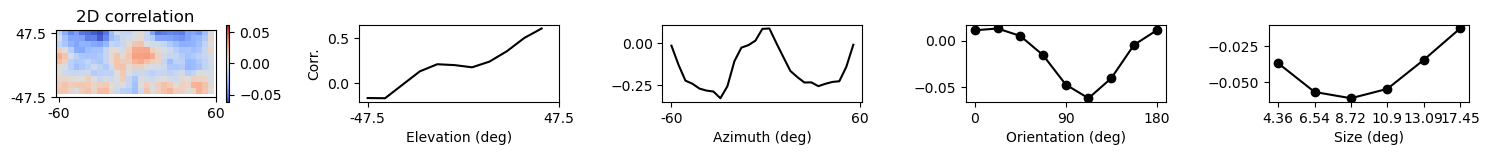

In [101]:
%matplotlib inline
fig, ax = plt.subplots(1, 5, figsize=(15, 1.5))
tuning_curve  = Waven.Analysis_Utils.PlotTuningCurve_Marcel(rfs_zebra, 
                                                    idx, 
                                                    analysis_coverage, 
                                                    sigmas_deg, 
                                                    screen_ratio, 
                                                    canvas=(fig, ax),
                                                    show=True
                                                    )

fig.tight_layout()

---

In [133]:
unit_name

'7e794edb-4a80-4089-95f4-a3bd5e62462f'

In [ ]:
df_res_sta[(df_res_sta['unit_name'] == unit_name) & ]

In [154]:
# Set Data dir in utils!

N = 100
df_tmp = df_res_sta[:N]

unique_files = df_tmp['origin_file'].unique()

elevations = []
azimuths = []
orientations = []
sizes = []
unit_names_list = []
files_list = []

for dandi_filepath in unique_files:

    dandiset_id =  utils.dandiset_id
    dandi_dirpath = utils.dandi_dirpath
    nwb = utils.load_dandi(dandi_filepath, dandiset_id, dandi_dirpath)
    df_units = nwb.units.to_dataframe()

    df_tmp_sub = df_tmp[df_tmp['origin_file'] == dandi_filepath]
    unit_names = df_tmp_sub['unit_name']

    for unit_name in unit_names:
        print(f'>>>> {df_tmp[df_tmp["unit_name"] == unit_name].index[0]+1}/{N} - {unit_name} <<<<')

        #load precomputed results
        df_pre = pd.read_csv('../../results/allen_open_scope/rf/waven/zebra/precomputed_waven_zebra_units.csv')
        if unit_name in df_pre['unit_name'].values:
            elevations.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_elevation'].values[0])
            azimuths.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_azimuth'].values[0])
            orientations.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_orientation'].values[0])
            sizes.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_size'].values[0])
            unit_names_list.append(unit_name)
            files_list.append(dandi_filepath)
            continue

        spike_times = df_units.loc[df_units['unit_name'] == unit_name, 'spike_times'].values[0]
        spike_times = neo.core.SpikeTrain(spike_times, t_start=spike_times[0], t_stop=spike_times[-1], units=pq.s)

        tmp = []
        for i, row in df_zebra.iterrows():
            start_time = row['start_time']
            stop_time = row['stop_time']
            rate = len(spike_times.time_slice(start_time, stop_time))/((stop_time - start_time)*pq.s)
            rate = rate.rescale('Hz').magnitude
            tmp.append(rate)
        neuron_rate_to_zebra_frames = np.array(tmp).reshape(1, -1)


        neuron_pos = np.zeros((1,2))  # dummy value for neuron_pos

        rfs_zebra = au.PearsonCorrelationPinkNoise(stim=wavelet_c.reshape(9000, -1), 
                                           resp=neuron_rate_to_zebra_frames.reshape(9000, -1),
                                           neuron_pos=neuron_pos, 
                                           nx=27, 
                                           ny=11, 
                                           ns=ns, 
                                           visual_coverage=analysis_coverage, 
                                           screen_ratio=screen_ratio, 
                                           sigmas=sigmas_deg,
                                           plotting=False,
                                           )

        tuning_curve  = Waven.Analysis_Utils.PlotTuningCurve_Marcel(rfs_zebra, 
                                                            0, 
                                                            analysis_coverage, 
                                                            sigmas_deg, 
                                                            screen_ratio, 
                                                            show=False)
        elevation = tuning_curve[1]
        y_min = visual_coverage[3]
        y_max = visual_coverage[2]
        ys = np.linspace(y_min, y_max, elevation.shape[0])
        max_elevation = ys[np.where(np.abs(elevation)==np.abs(elevation).max())[0][0]]

        azimuth = tuning_curve[2]
        x_min = visual_coverage[0]
        x_max = visual_coverage[1]
        xs = np.linspace(x_min, x_max, azimuth.shape[0])
        max_azimuth = xs[np.where(np.abs(azimuth)==np.abs(azimuth).max())[0][0]]

        orientation = tuning_curve[3]
        xs = np.linspace(0, 180, orientation.shape[0])
        max_orientation= xs[np.where(np.abs(orientation)==np.abs(orientation).max())[0][0]]

        size = tuning_curve[4]
        max_size = sigmas_deg[np.where(np.abs(size)==np.abs(size).max())[0][0]]

        elevations.append(max_elevation)
        azimuths.append(max_azimuth)
        orientations.append(max_orientation)
        sizes.append(max_size)

        unit_names_list.append(unit_name)
        files_list.append(dandi_filepath)

        df_save = pd.DataFrame({
            'unit_name': unit_names_list,
            'file': files_list,
            'waven_max_elevation': elevations,
            'waven_max_azimuth': azimuths,
            'waven_max_orientation': orientations,
            'waven_max_size': sizes
        })

        df_save.to_csv('../../results/allen_open_scope/rf/waven/zebra/waven_zebra_units.csv', index=False)


Processing file: sub-820454_ses-ecephys-820454-2025-11-04-14-59-22_ecephys.nwb
File already exists


/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 1/100 - 7e794edb-4a80-4089-95f4-a3bd5e62462f <<<<
>>>> 10/100 - e18e1dca-b05e-4d01-90c2-969a0f27ca6e <<<<
>>>> 13/100 - 161c047a-738a-466d-b031-71cb24c95c3d <<<<
>>>> 17/100 - c9ba971b-e415-47b6-b8c8-601a816562e8 <<<<
>>>> 22/100 - de063e4a-4c6a-4a59-9a29-7d39ffba9780 <<<<
>>>> 23/100 - b6be9fce-626b-47f6-b493-1c6684c1b726 <<<<
>>>> 24/100 - 35228a58-fdb0-4f50-9bf9-fa5050df8b5f <<<<
>>>> 31/100 - 71901fab-bfae-4ea3-95c5-a21162a3eb6d <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 32/100 - 26751dfc-9ca0-41f1-9675-dae45e94c595 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 33/100 - 7c27af02-1f8f-41c1-b3dd-fc75bd98ff16 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 37/100 - 7b65caf4-8751-4e29-9f0a-e123e28d1883 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 40/100 - 76cd3d84-d1ba-44c0-bac9-61fc708b26de <<<<
torch.Size([14257, 14257]

/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 2/100 - 5d77b1fc-ad53-44c1-8d6d-d48488f4cccb <<<<
>>>> 3/100 - 46e619d9-8a85-4edf-b416-022d2aa1f844 <<<<
>>>> 7/100 - c0b2ffd0-3e99-4262-94ed-ebd42081beb8 <<<<
>>>> 21/100 - b091015a-83a9-4a71-a18b-ec7d936e611d <<<<
>>>> 28/100 - 967fc5d3-48ae-4683-ae04-e1c8f4f0a066 <<<<
>>>> 34/100 - 88d207ea-4514-4e52-b7ae-feab4668da1e <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 35/100 - ef656b8e-239f-476e-89b2-7888c6e6d06f <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 39/100 - 53484720-60a4-48a6-8f19-6627f37bf9fa <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 44/100 - 9e3554e6-e6da-427b-8300-4f55a2d334bc <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 46/100 - 821f6f0f-de54-4bff-8ea6-0b21a67db188 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 52/100 - 601c3b07-b825-45a0-9144-48b860e55e80 <<<<
torch.S

/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 4/100 - bab57985-6c06-4470-8ac7-3c8cc9f5bf41 <<<<
>>>> 5/100 - 3df4c9de-edb1-44a9-870e-4cad737be475 <<<<
>>>> 6/100 - 780b5eb6-ec49-40b9-8aba-3efd5a28fd97 <<<<
>>>> 8/100 - 295725ec-736e-4f85-af5e-1b5a89361b0d <<<<
>>>> 9/100 - edf6ac01-7646-4a8f-83f9-42f7586d8775 <<<<
>>>> 11/100 - dc06f37a-3bc8-4c61-ae7d-dc29609f0b78 <<<<
>>>> 12/100 - 5794d0b0-61e0-432f-acba-35c1245daa47 <<<<
>>>> 14/100 - 0f0f08fe-ff0d-400a-bea2-8dfcbe6572a6 <<<<
>>>> 15/100 - 66deca72-ccb2-4fc9-9dad-418aacf3481c <<<<
>>>> 18/100 - 4bf8abd9-bc12-435d-b29b-eab596b9ca6e <<<<
>>>> 20/100 - 16192316-78ad-46a0-8da1-e676355662f4 <<<<
>>>> 25/100 - 4dd02edc-dd26-47a2-816b-76412adcb60d <<<<
>>>> 26/100 - 5fc3c280-fb92-49ed-947f-0146a297d752 <<<<
>>>> 27/100 - 61f97456-4063-4bcb-b88f-93d7dc5f7e9b <<<<
>>>> 29/100 - c8e59744-d513-4b41-bf87-b3790b624976 <<<<
>>>> 30/100 - 8871cc7c-4e87-4227-a472-88b94e994148 <<<<
>>>> 36/100 - 7e0d814f-f892-4513-83d6-58f66e43a0a0 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8

/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 16/100 - c4cc7470-3112-4cab-9678-dcba347b9ae8 <<<<
>>>> 19/100 - cc89c9b1-cc8e-4d81-96a6-ec693f4fd79e <<<<
>>>> 50/100 - bdb3db31-42af-4bda-bbf3-2492d5161a9b <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 54/100 - 8e2e5f94-c181-4c92-9e35-3c7e224c3e9e <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 59/100 - 8acc499f-bef3-46b3-a8cb-2a3b84a7c18b <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 64/100 - 8bf7248b-4d4b-409f-afe9-03cf0dc91a6a <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 65/100 - ebd92278-cb87-4b09-8589-b68b4f7d3081 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 72/100 - 963a0ee3-4dfa-4902-9549-39e3d4cb527a <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 76/100 - dcd08243-ccd6-40e4-8131-3bc8e17f5839 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 

In [152]:
df_save = pd.DataFrame({
    'unit_name': unit_names_list,
    'file': files_list,
    'waven_max_elevation': elevations,
    'waven_max_azimuth': azimuths,
    'waven_max_orientation': orientations,
    'waven_max_size': sizes
})

df_save.to_csv('../../results/allen_open_scope/rf/waven/zebra/waven_zebra_units.csv', index=False)

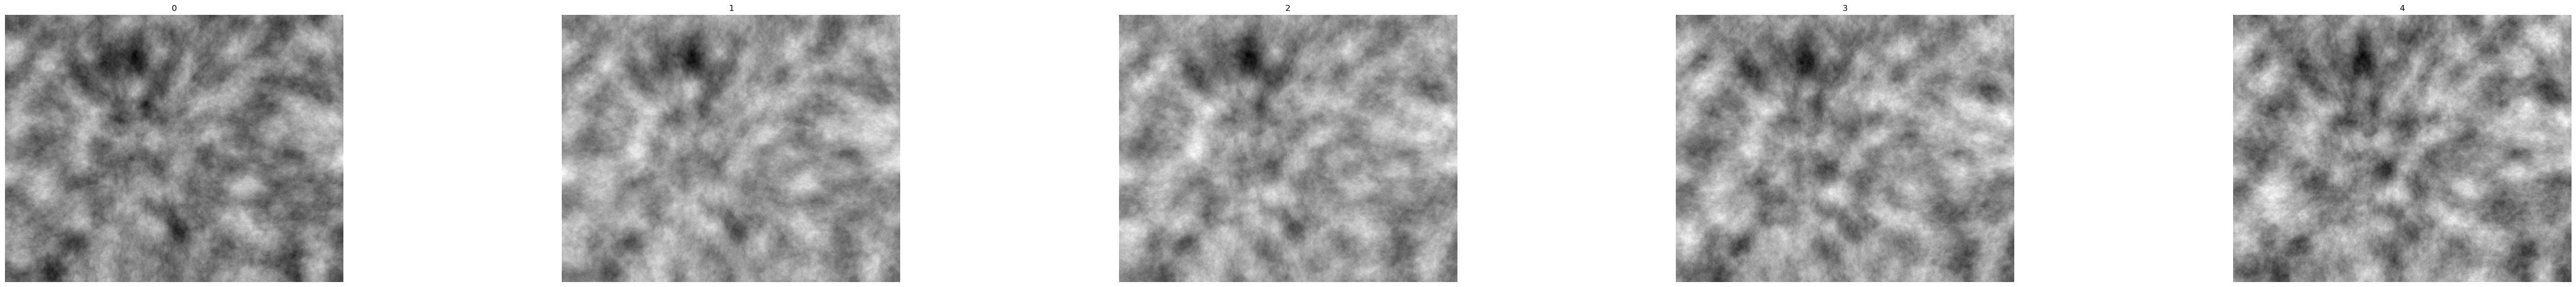

In [71]:
import h5py
fname = common_units.loc[idxs[0], 'file']

with h5py.File(RESULTS_DIR+fname, 'r') as hdf:
    unit = list(hdf.keys())[0]
    sta_grid = hdf[unit]['frames'][:]


f, axs = plt.subplots(1, 5, figsize=(10*7, 7))

for i in range(5):
    # axs[j, i].imshow(sta_grid[i], cmap='gray', vmin=0, vmax=1)
    axs[i].axis('off')
    axs[i].set_title(i)
    axs[i].imshow(sta_grid[i], cmap='gray')
